# Getting started with the Stackdriver Monitoring API

Cloud Datalab provides an environment for working with your data. This includes data that is being managed within the [Stackdriver Monitoring API](https://cloud.google.com/monitoring/api/v3/). This notebook introduces some of the APIs that Cloud Datalab provides for working with the monitoring data, and allows you to try them out on your own project.

The main focus of this API is to allow you to query time series data for your monitored resources. The time series, and it's metadata are returned as [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) objects. `pandas` is a widely used library for data manipulation, and is well suited to working with time series data.

**Note**: This notebook will show you how to use this API with your own project. The charts included here are from a sample project that you will not have access to. For all cells to run without errors, the following must hold:
* The default project must be set
* This project must have at least one GCE Instance. You can create an instance at the following link: https://console.cloud.google.com/compute/instances

## Importing the API and setting up the default project

The Monitoring functionality is contained within the `datalab.stackdriver.monitoring` module.

If the default project is not already set via the environment variable `$PROJECT_ID`, you must do so using `'set_datalab_project_id'`, or using the `%datalab config` magic.

In [26]:
# set_datalab_project_id('my-project-id')

First, list supported options on the Stackdriver magic `%sd`:

In [27]:
%sd -h

usage: sd [-h] {monitoring} ...

Execute various Stackdriver related operations. Use "%sd <stackdriver_product>
-h" for help on a specific Stackdriver product.

positional arguments:
  {monitoring}  commands
    monitoring  Execute Stackdriver monitoring related operations. Use "sd
                monitoring <command> -h" for help on a specific command

optional arguments:
  -h, --help    show this help message and exit
None


Let's see what we can do with the monitoring command:

In [28]:
%sd monitoring -h

usage: sd monitoring [-h] {metrics,resource_types,groups} ...

Execute Stackdriver monitoring related operations. Use "sd monitoring
<command> -h" for help on a specific command

positional arguments:
  {metrics,resource_types,groups}
                        commands
    metrics             Operations on Stackdriver Monitoring metrics
    resource_types      Operations on Stackdriver Monitoring resource types
    groups              Operations on Stackdriver groups

optional arguments:
  -h, --help            show this help message and exit
None


## List names of Compute Engine CPU metrics

Here we use IPython [cell magics](http://ipython.readthedocs.io/en/stable/interactive/magics.html) to list the CPU metrics. The `Labels` column shows that `instance_name` is a metric label.

In [29]:
%sd monitoring metrics list --type compute*/cpu/*

Metric type,Display name,Kind,Value,Unit,Labels
compute.googleapis.com/instance/cpu/reserved_cores,Reserved cores,GAUGE,DOUBLE,1,instance_name
compute.googleapis.com/instance/cpu/usage_time,CPU usage,DELTA,DOUBLE,s,instance_name
compute.googleapis.com/instance/cpu/utilization,CPU utilization,GAUGE,DOUBLE,1,instance_name


## List monitored resource types related to GCE

In [30]:
%sd monitoring resource_types list --type gce*

Resource type,Display name,Labels
gce_disk,GCE Disk,"project_id, disk_id, zone"
gce_instance,GCE VM Instance,"project_id, instance_id, zone"
gce_router,Cloud Router,"project_id, router_id, region"


# Querying time series data

The `Query` class allows users to query and access the monitoring time series data.

Many useful methods of the `Query` class are actually defined by the base class, which is provided by the `google-cloud-python` library. These methods include:
* `select_metrics`:  filters the query based on metric labels.
* `select_resources`: filters the query based on resource type and labels.
* `align`: aligns the query along the specified time intervals.
* `reduce`: applies aggregation to the query.
* `as_dataframe`: returns the time series data as a `pandas` DataFrame object.

Reference documentation for the `Query` base class is available [here](http://gcloud-python.readthedocs.org/en/latest/monitoring-query.html). You can also get help from inside the notebook by calling the `help` function on any class, object or method.

In [31]:
from google.datalab.stackdriver import monitoring as gcm
help(gcm.Query.select_interval)

Help on method select_interval in module google.cloud.monitoring.query:

select_interval(self, end_time, start_time=None) unbound google.datalab.stackdriver.monitoring._query.Query method
    Copy the query and set the query time interval.
    
    Example::
    
        import datetime
    
        now = datetime.datetime.utcnow()
        query = query.select_interval(
            end_time=now,
            start_time=now - datetime.timedelta(minutes=5))
    
    As a convenience, you can alternatively specify the end time and
    an interval duration when you create the query initially.
    
    :type end_time: :class:`datetime.datetime`
    :param end_time: The end time (inclusive) of the time interval
        for which results should be returned, as a datetime object.
    
    :type start_time: :class:`datetime.datetime` or None
    :param start_time: The start time (exclusive) of the time interval
        for which results should be returned, as a datetime object.
        If not sp

## Initializing the query

During intialization, the metric type and the time interval need to be specified. For interactive use, the metric type has a default value. The simplest way to specify the time interval that ends `now` is to use the arguments `days`, `hours`, and `minutes`.

In the cell below, we initialize the query to load the time series for `CPU Utilization` for the last two hours.

In [32]:
query_cpu = gcm.Query('compute.googleapis.com/instance/cpu/utilization', hours=2)

## Getting the metadata

The method `metadata()` returns a `QueryMetadata` object. It contains the following information about the time series matching the query:
* resource types
* resource labels and their values
* metric labels and their values

This helps you understand the structure of the time series data, and makes it easier to modify the query.

In [33]:
metadata_cpu = query_cpu.metadata().as_dataframe()
metadata_cpu.head(5)

resource.type    resource.labels                                     \
                        project_id           zone         instance_id   
0  gce_instance  yelsayed-project1  us-central1-b  428882731927323020   

  metric.labels  
  instance_name  
0           dev

### Reading the instance names from the metadata
Next, we read in the instance names from the metadata, and use it in filtering the time series data below. If there are no GCE instances in this project, the cells below will raise errors.

In [34]:
import sys

if metadata_cpu.empty:
  sys.stderr.write('This project has no GCE instances. The remaining notebook '
                   'will raise errors!')
else:
  instance_names = sorted(list(metadata_cpu['metric.labels']['instance_name']))
  print 'First 5 instance names: %s' % ([str(name) for name in instance_names[:5]],)

First 5 instance names: ['dev']


## Filtering by metric label

We first filter `query_cpu` defined earlier to include only the first instance. Next, calling `as_dataframe` gets the results from the monitoring API, and converts them into a `pandas` DataFrame.

In [35]:
query_cpu_single_instance = query_cpu.select_metrics(instance_name=instance_names[0])

# Get the query results as a pandas DataFrame and look at the last 5 rows.
data_single_instance = query_cpu_single_instance.as_dataframe(label='instance_name')
data_single_instance.tail(5)

,dev
2017-03-06 18:52:01.763,0.006553
2017-03-06 18:53:01.763,0.005854
2017-03-06 18:54:01.763,0.006008
2017-03-06 18:55:01.763,0.008540
2017-03-06 18:56:01.763,0.011653


## Displaying the time series as a linechart

We can plot the time series data by calling the plot method of the dataframe. The `pandas` library uses `matplotlib` for plotting, so you can learn more about it [here](http://matplotlib.org/users/pyplot_tutorial.html).

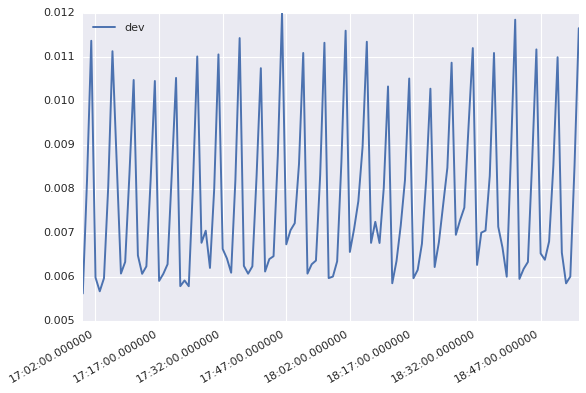

In [36]:
# N.B. A useful trick is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

_ = data_single_instance.plot()

## Aggregating the query

You can aggregate or summarize time series data along various dimensions.
* In the first stage, data in a time series is [aligned](https://cloud.google.com/monitoring/api/ref_v3/rest/v3/projects.timeSeries/list#Aligner) to a specified period.
* In the second stage, data from multiple time series is combined, or [reduced](https://cloud.google.com/monitoring/api/ref_v3/rest/v3/projects.timeSeries/list#Reducer), into one time series. 

Not all alignment and reduction options are applicable to all time series, depending on their metric type and value type. Alignment and reduction may change the metric type or value type of a time series.

### Aligning the query

For multiple time series, aligning the data is recommended. Aligned data is more compact to read from the Monitoring API, and lends itself better to visualizations.

The alignment period can be specified using the arguments `hours`, `minutes`, and `seconds`. In the cell below, we do the following:
* select a subset of the instances by using a prefix of the first instance name
* align the time series to 5 minute intervals using an `'ALIGN_MEAN'` method.
* plot the time series, and adjust the legend to be outside the plot. You can learn more about legend placement [here]( http://matplotlib.org/users/legend_guide.html).

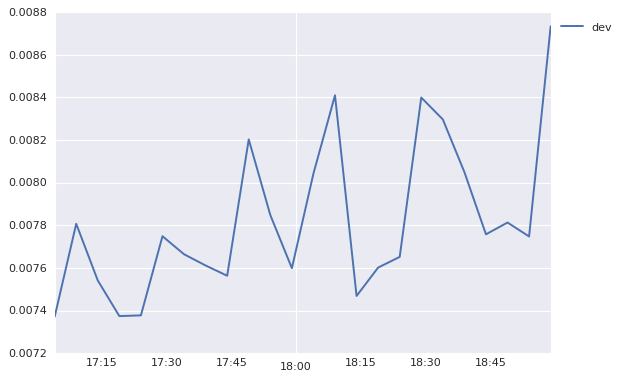

In [37]:
# Filter the query by a common instance name prefix.
common_prefix = instance_names[0].split('-')[0]
query_cpu_aligned = query_cpu.select_metrics(instance_name_prefix=common_prefix)

# Align the query to have data every 5 minutes.
query_cpu_aligned = query_cpu_aligned.align(gcm.Aligner.ALIGN_MEAN, minutes=5)
data_multiple_instances = query_cpu_aligned.as_dataframe(label='instance_name')

# Display the data as a linechart, and move the legend to the right of it.
_ = data_multiple_instances.plot().legend(loc="upper left", bbox_to_anchor=(1,1))

### Reducing the query

In order to combine the data across multiple time series, the `reduce()` method can be used. The fields to be retained after aggregation must be specified in the method.

For example, to aggregate the results by the zone, `'resource.zone'` can be specified.

In [38]:
query_cpu_reduced = query_cpu_aligned.reduce(gcm.Reducer.REDUCE_MEAN, 'resource.zone')
data_per_zone = query_cpu_reduced.as_dataframe('zone')
data_per_zone.tail(5)

,us-central1-b
2017-03-06 18:39:00,0.008050
2017-03-06 18:44:00,0.007758
2017-03-06 18:49:00,0.007813
2017-03-06 18:54:00,0.007748
2017-03-06 18:59:00,0.008734


## Displaying the time series as a heatmap

Let us look at the time series at the instance level as a heatmap. A heatmap is a compact representation of the data, and can often highlight patterns.

The diagram below shows the instances along rows, and the timestamps along columns.

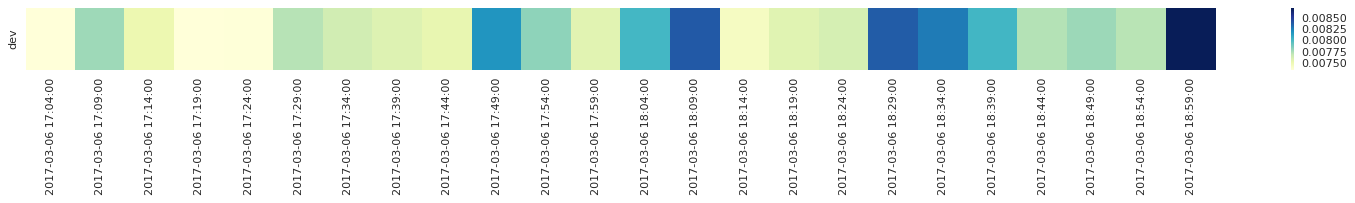

In [39]:
import matplotlib
import seaborn

# Set the size of the heatmap to have a better aspect ratio.
div_ratio = 1 if len(data_multiple_instances.columns) == 1 else 2.0
width, height = (size/div_ratio for size in data_multiple_instances.shape)
matplotlib.pyplot.figure(figsize=(width, height))

# Display the data as a heatmap. The timestamps are converted to strings
# for better readbility.
_ = seaborn.heatmap(data_multiple_instances.T,
                    xticklabels=data_multiple_instances.index.map(str),
                    cmap='YlGnBu')

## Multi-level headers

If you don't provide any labels to `as_dataframe`, it returns all the resource and metric labels present in the time series as a multi-level header.

This allows you to filter, and aggregate the data more easily.

In [40]:
data_multi_level = query_cpu_aligned.as_dataframe()
data_multi_level.tail(5)

resource_type,gce_instance
project_id,yelsayed-project1
zone,us-central1-b
instance_id,428882731927323020
instance_name,dev
2017-03-06 18:39:00,0.008050
2017-03-06 18:44:00,0.007758
2017-03-06 18:49:00,0.007813
2017-03-06 18:54:00,0.007748
2017-03-06 18:59:00,0.008734


### Filter the dataframe

Let us filter the multi-level dataframe based on the common prefix. Applying the filter will look across all column headers.

In [41]:
print 'Finding pattern "%s" in the dataframe headers' % (common_prefix,)

Finding pattern "dev" in the dataframe headers


In [42]:
data_multi_level.filter(regex=common_prefix).tail(5)

resource_type,gce_instance
project_id,yelsayed-project1
zone,us-central1-b
instance_id,428882731927323020
instance_name,dev
2017-03-06 18:39:00,0.008050
2017-03-06 18:44:00,0.007758
2017-03-06 18:49:00,0.007813
2017-03-06 18:54:00,0.007748
2017-03-06 18:59:00,0.008734


### Aggregate columns in the dataframe

Here, we aggregate the multi-level dataframe at the `zone` level. This is similar to applying reduction using `'REDUCE_MEAN'` on the field `'resource.zone'`.

In [43]:
data_multi_level.groupby(level='zone', axis=1).mean().tail(5)

zone,us-central1-b
2017-03-06 18:39:00,0.008050
2017-03-06 18:44:00,0.007758
2017-03-06 18:49:00,0.007813
2017-03-06 18:54:00,0.007748
2017-03-06 18:59:00,0.008734
